### Setting up the dataset, model and loader

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm

from TicketClassifierModel import BertClassifier
from TicketLoader import Loader


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!pwd
os.chdir('/content/drive/My Drive/Track 4_SK')
!pwd

Mounted at /content/drive
/content
/content/drive/My Drive/Track 4_SK


In [4]:
import numpy as np
torch.manual_seed(42)

In [5]:
data='DATA'
raw_data_folder='RAW_DATA'
processed_data_folder='PROCESSED_DATA'
DATA_PATH=os.path.join(data)
RAW_DATA_PATH=os.path.join(DATA_PATH,raw_data_folder)
PROCESSED_DATA_PATH=os.path.join(DATA_PATH,processed_data_folder)
TRAIN_PATH=os.path.join(PROCESSED_DATA_PATH,'TRAIN')
TEST_PATH=os.path.join(PROCESSED_DATA_PATH,'TEST')

In [6]:
folders=['MODELS','LOGS']
for f in folders:
    if f not in os.listdir(os.getcwd()):
        os.makedirs(os.path.join(f))
MODEL_PATH=os.path.join('MODELS')
LOG_PATH=os.path.join('LOGS')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
from torch.utils.data import Dataset, DataLoader

### TRAINING

#### Load the data

In [21]:
X_train_input=torch.load('DATA/PROCESSED_DATA/TRAIN/X_train_tokens.pt')
y_train=torch.load('DATA/PROCESSED_DATA/TRAIN/y_train_tokens.pt')

In [22]:
X_train_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [23]:
X_train=X_train_input['input_ids']
X_train_mask=X_train_input['attention_mask']
train_samples=y_train.shape[0]
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [24]:
balances=torch.Tensor(np.load('DATA/PROCESSED_DATA/TRAIN/balance.npy'))
balances=balances.to(device)
print(balances.shape)
print(balances.is_cuda)

torch.Size([44])
False


In [25]:
dataset=Loader(X_train,X_train_mask,y_train)

In [26]:
batch_size=16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
for item in dataloader:
    print,('Shape of input tokens',item[0].shape)
    print('Shape of attention mask',item[1].shape)
    print('Shape of label',item[2].shape)
    print('No. of tokens as per attention mask',item[1][0].sum().item())
    print('No. of tokens as per input tokens',len(torch.where(item[0][0]>0)[0]))
    break

Shape of attention mask torch.Size([16, 512])
Shape of label torch.Size([16])
No. of tokens as per attention mask 172
No. of tokens as per input tokens 172


In [28]:
ok_flag=True
for item in dataloader:
    r=item[1].shape[0]
    for row in range(r):
        attn_count=item[1][row].sum().item()
        token_count=len(torch.where(item[0][row]>0)[0])
        if attn_count!=token_count:
            ok_flag=False
            print('Issue')
print(ok_flag)

True


In [29]:
def get_accuracy(y_pred,y_act):
    acc = torch.sum(torch.argmax(y_pred,axis=1)==y_act).item()
    return acc 

#### Define the model

In [11]:
bert1=BertClassifier()
bert1.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [12]:
del bert1

#### Define train parameters

In [ ]:
epochs = 100
path="model.pt"

In [ ]:
try:
  checkpoint=torch.load('model.pt',map_location=torch.device(device))
  print('Key details loaded:',checkpoint.keys())
  bert1.load_state_dict(checkpoint['model_state_dict'])
  optim.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs_complete = checkpoint['epoch']
  loss = checkpoint['loss']
except:
  print('No checkpoint found')
  optim=torch.optim.Adam(bert1.parameters(), lr=5e-6)
  epochs_complete=0

Key details loaded: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


#### Train !

In [ ]:
try:
  del checkpoint, balances, X_train,X_train_mask,y_train,X_train_input
except:
  del balances, X_train,X_train_mask,y_train,X_train_input

In [ ]:
def generate_dataset(batch_size=16):
  X_train_input=torch.load('DATA/PROCESSED_DATA/TRAIN/X_train_tokens.pt')
  y_train=torch.load('DATA/PROCESSED_DATA/TRAIN/y_train_tokens.pt')
  X_train=X_train_input['input_ids']
  X_train_mask=X_train_input['attention_mask']
  dataset=Loader(X_train,X_train_mask,y_train)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  del X_train_input,y_train,X_train,X_train_mask
  return dataloader

In [ ]:
print(epochs_complete)

97


In [ ]:
for g in optim.param_groups:
        g['lr'] = 4e-6

In [ ]:
final_loss=[]
final_accuracy=[]
for e in range(epochs_complete, epochs):
    loss_epoch=0
    acc_epoch=0
    i=0
    dataloader=generate_dataset()
    if e>25:
      for g in optim.param_groups:
          g['lr'] = min(g['lr']*0.9999, 1e-7)
    for token,mask,label in tqdm(dataloader):
      out=bert1(token.to(device),mask.to(device))
      out=out.to(device)
      label=label.to(device)
      loss=criterion(out,label)
      loss_epoch+=loss.item()
      acc=get_accuracy(out,label)
      acc_epoch+=acc
      optim.zero_grad()
      loss.backward()
      optim.step()
      batch_no=(e*batch_size)+i
      writer.add_scalar("Batch Loss/train", loss/batch_size, batch_no)
      writer.add_scalar("Batch Accuracy/train", acc/batch_size, batch_no)
      i+=1
    print(f'Epoch: {e}\tbatch: {i}\tloss: {loss}\taccuracy:{acc}')
    final_loss.append(loss_epoch)
    final_accuracy.append(acc_epoch)
    writer.add_scalar("Epoch Loss/train", loss_epoch/train_samples, e)
    writer.add_scalar("Epoch Accuracy/train", acc_epoch/train_samples, e)
    torch.save({
            'epoch': e+epochs_complete,
            'model_state_dict': bert1.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss},
            path)

100%|██████████| 505/505 [11:26<00:00,  1.36s/it]


Epoch: 97	batch: 505	loss: 3.2021195888519287	accuracy:7


100%|██████████| 505/505 [11:25<00:00,  1.36s/it]


Epoch: 98	batch: 505	loss: 2.8875672817230225	accuracy:9


100%|██████████| 505/505 [11:25<00:00,  1.36s/it]


Epoch: 99	batch: 505	loss: 2.965332269668579	accuracy:9


In [ ]:
torch.save(bert1,os.path.join(MODEL_PATH,'track4_model_2.pt'))

### TESTING

In [13]:
device='cpu'

#### Load the data

In [14]:
X_test_input=torch.load(os.path.join(TEST_PATH,'X_test_tokens.pt'))
y_test=torch.load(os.path.join(TEST_PATH,'y_test_tokens.pt'))
X_test=X_test_input['input_ids']
X_test_mask=X_test_input['attention_mask']
y_test.shape

torch.Size([425])

In [15]:
ref_y_dict={'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 'GRP_1': 9,
 'GRP_10': 10,
 'GRP_11': 11,
 'GRP_12': 12,
 'GRP_13': 13,
 'GRP_14': 14,
 'GRP_15': 15,
 'GRP_16': 16,
 'GRP_17': 17,
 'GRP_18': 18,
 'GRP_19': 19,
 'GRP_2': 20,
 'GRP_20': 21,
 'GRP_22': 22,
 'GRP_24': 23,
 'GRP_25': 24,
 'GRP_26': 25,
 'GRP_28': 26,
 'GRP_29': 27,
 'GRP_3': 28,
 'GRP_30': 29,
 'GRP_31': 30,
 'GRP_33': 31,
 'GRP_34': 32,
 'GRP_4': 33,
 'GRP_40': 34,
 'GRP_41': 35,
 'GRP_42': 36,
 'GRP_45': 37,
 'GRP_5': 38,
 'GRP_6': 39,
 'GRP_7': 40,
 'GRP_8': 41,
 'GRP_9': 42,
 'other': 43}

Based on our K-means split of GRP_0, we know that labels 0-8 all refer to Grp-0. We will combine these labels and use the same while checking the loss and accuract

In [16]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35,
       36, 37, 38, 39, 40, 41, 42, 43])

In [17]:
test_samples=y_test.shape[0]

In [18]:
test_batch_size=8

In [19]:
test_dataset=Loader(X_test,X_test_mask,y_test)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

In [20]:
balances=torch.Tensor(np.load(os.path.join(TRAIN_PATH,'balance.npy')))
balances=balances.to(device)
print(balances.shape)
print(balances.is_cuda)

torch.Size([44])
False


#### Define the model

In [21]:
bert2=BertClassifier()
bert2.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [22]:
criterion = nn.CrossEntropyLoss(weight=balances)
writer=SummaryWriter(log_dir=LOG_PATH)

#### Define test parameters

In [23]:
try:
  checkpoint=torch.load('model.pt',map_location=torch.device(device))
  print('Key details loaded:',checkpoint.keys())
  bert2.load_state_dict(checkpoint['model_state_dict'])
except:
  print('No checkpoint found')

Key details loaded: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [24]:
bert2.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [25]:
def get_test_accuracy(y_pred,y_act):
  y_pred_max=torch.argmax(y_pred,axis=1)
  out_ref=torch.tensor([torch.tensor(0) if i.item()<9 else i for i in y_pred_max])
  label_ref=torch.tensor([torch.tensor(0) if i.item()<9 else i for i in y_act])
  acc = torch.sum(out_ref==label_ref).item()
  return acc 

In [26]:
try:
  del checkpoint, balances, X_test,X_test_mask,X_test_input, y_test
except:
  del balances, X_test,X_test_mask,X_test_input, y_test

#### TEST!

In [27]:
# accuracy_data=0
loss_data=0
total_y_test_pred=[]
total_y_test=[]
accuracy_data=0
batch_no=1
for token,mask,label in iter(test_dataloader):
  out=bert2(token.to(device),mask.to(device))
  out=out.to(device)
  label=label.to(device)
  total_y_test_pred.append(torch.argmax(out,axis=1).detach().cpu().numpy())
  total_y_test.append(label.detach().cpu().numpy())
  loss=criterion(out,label)
  loss_data+=loss.item()
  acc=get_test_accuracy(out,label)
  accuracy_data+=acc
  print('Batch: ',batch_no,'\tLoss:',loss.item(),'\tAccuracy:',acc/test_batch_size)
  writer.add_scalar("Epoch Loss/test", loss/test_batch_size, batch_no)
  writer.add_scalar("Epoch Accuracy/test", acc/test_batch_size, batch_no)
  batch_no+=1

Batch:  1 	Loss: 3.173800468444824 	Accuracy: 0.75
Batch:  2 	Loss: 3.444087266921997 	Accuracy: 0.625
Batch:  3 	Loss: 3.129258632659912 	Accuracy: 0.875
Batch:  4 	Loss: 2.9168002605438232 	Accuracy: 0.875
Batch:  5 	Loss: 3.4684691429138184 	Accuracy: 0.625
Batch:  6 	Loss: 2.9098260402679443 	Accuracy: 0.75
Batch:  7 	Loss: 3.081394910812378 	Accuracy: 0.875
Batch:  8 	Loss: 3.551316261291504 	Accuracy: 0.75
Batch:  9 	Loss: 3.2090349197387695 	Accuracy: 0.75
Batch:  10 	Loss: 3.4796791076660156 	Accuracy: 0.75
Batch:  11 	Loss: 3.170868396759033 	Accuracy: 0.625
Batch:  12 	Loss: 3.403073787689209 	Accuracy: 0.875
Batch:  13 	Loss: 3.333263874053955 	Accuracy: 0.625
Batch:  14 	Loss: 3.445063829421997 	Accuracy: 0.625
Batch:  15 	Loss: 3.310520648956299 	Accuracy: 0.875
Batch:  16 	Loss: 3.0890750885009766 	Accuracy: 1.0
Batch:  17 	Loss: 3.1629388332366943 	Accuracy: 0.875
Batch:  18 	Loss: 3.2488911151885986 	Accuracy: 0.625
Batch:  19 	Loss: 3.6191985607147217 	Accuracy: 0.625


#### Assess

In [37]:
def test_full_accuracy(pred, act):
  pred_class=[0 if i<9 else i for i in np.hstack(pred)]
  act_class=[0 if i<9 else i for i in np.hstack(act)]
  corr=np.sum(np.array(pred_class)==np.array(act_class))
  acc=corr/len(pred_class)
  return acc,pred_class, act_class

In [38]:
acc, preds,acts=test_full_accuracy(total_y_test_pred,total_y_test)
print('Accuracy on test class is', round(acc,3)*100,"%")

Accuracy on test class is 69.6 %


In [33]:
loss_average=loss_data/len(total_y_test)
print(f'Loss of the base model: {round(loss_average,2)}')

Loss of the base model: 3.31


In [39]:
import seaborn as sns

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
np.set_printoptions(threshold=np.inf)

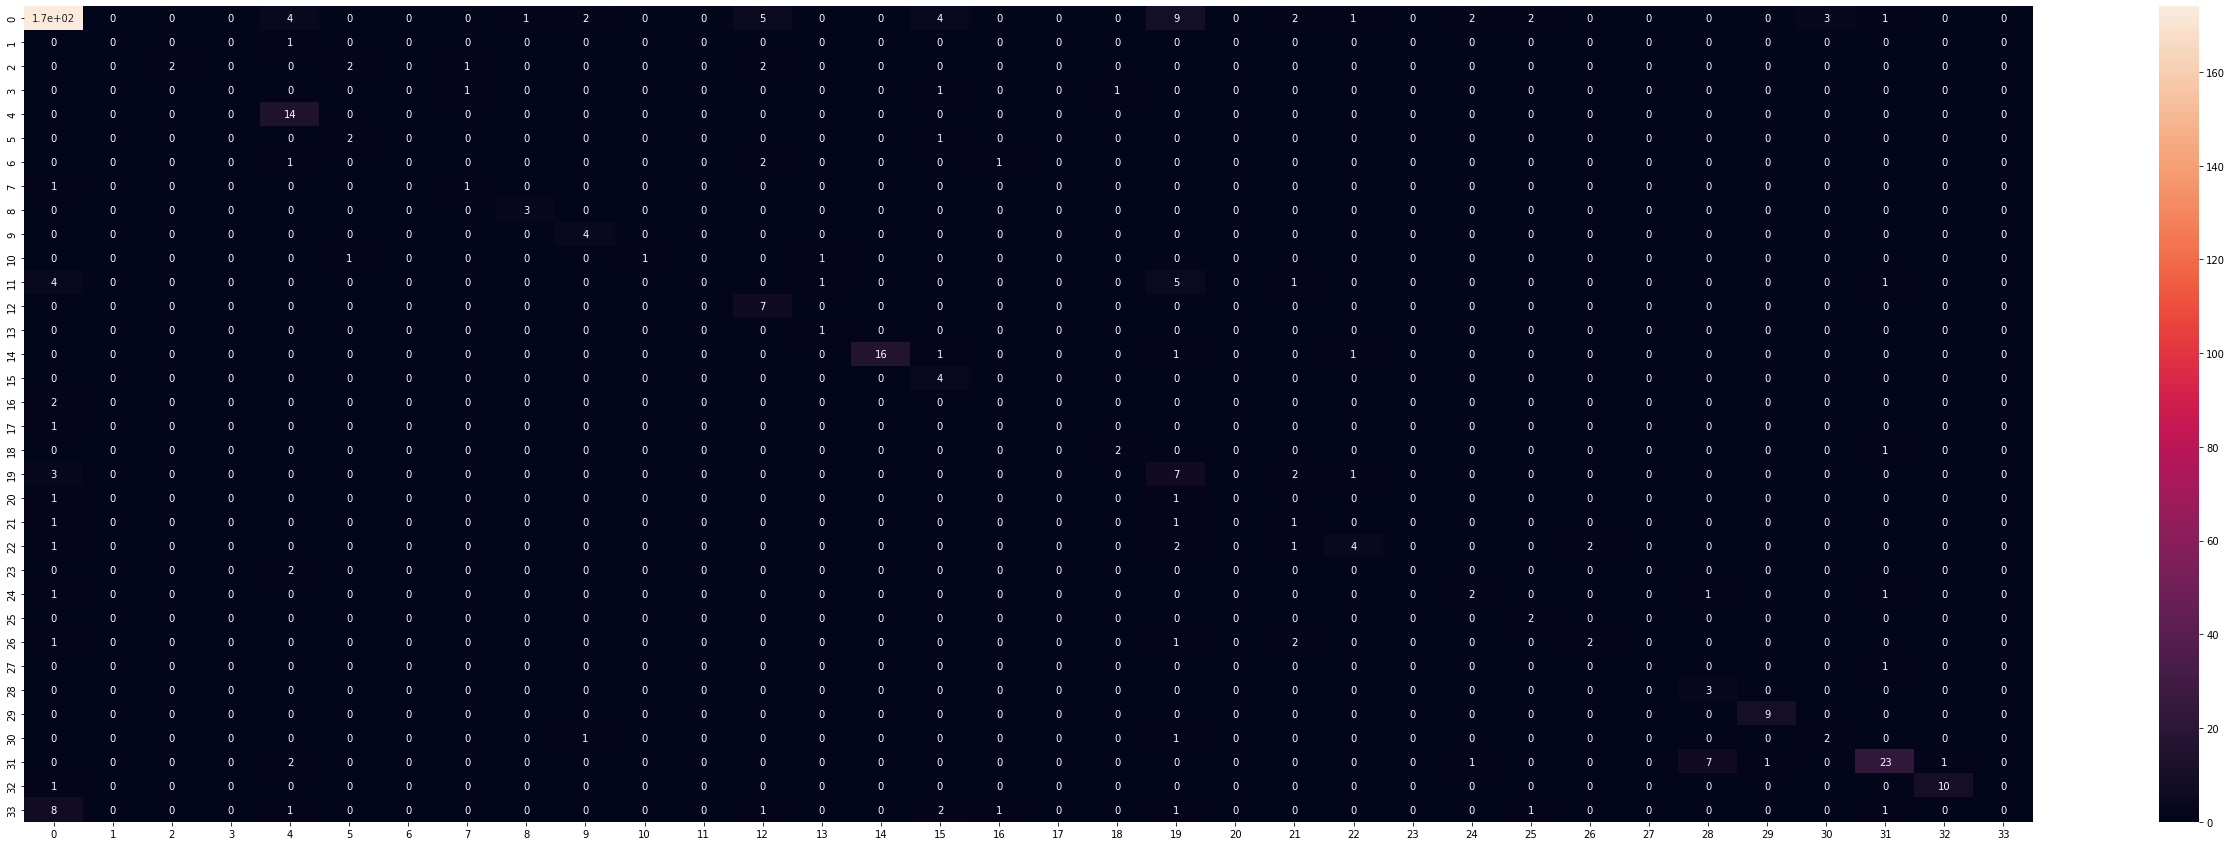

In [58]:
cf_matrix=confusion_matrix(acts, preds)
import seaborn as sns
fig, ax = plt.subplots(figsize=(45, 15))
sns.heatmap(cf_matrix,annot=True, 
          );

In [60]:
print(classification_report(acts, preds,zero_division=0))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       210
           9       0.00      0.00      0.00         1
          10       1.00      0.29      0.44         7
          11       0.00      0.00      0.00         3
          12       0.56      1.00      0.72        14
          13       0.40      0.67      0.50         3
          14       0.00      0.00      0.00         4
          15       0.33      0.50      0.40         2
          16       0.75      1.00      0.86         3
          17       0.57      1.00      0.73         4
          18       1.00      0.33      0.50         3
          19       0.00      0.00      0.00        12
          20       0.41      1.00      0.58         7
          21       0.33      1.00      0.50         1
          23       1.00      0.84      0.91        19
          24       0.31      1.00      0.47         4
          25       0.00      0.00      0.00         2
          26       0.00    

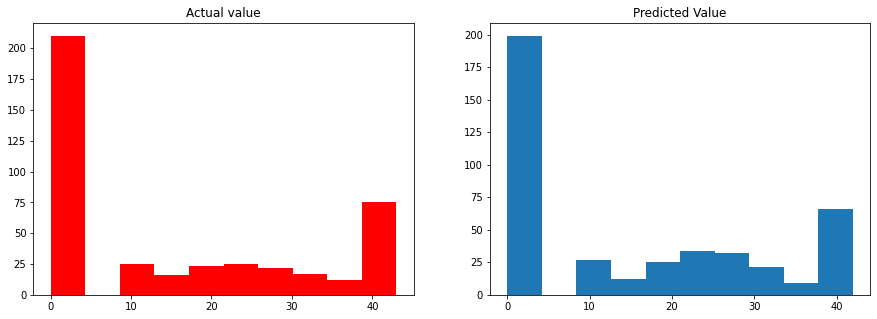

In [61]:
figure, axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
axes[0].hist(acts,color='red')
axes[0].set_title('Actual value')
axes[1].hist(preds)
axes[1].set_title('Predicted Value')
plt.show();
